# Text-based Information Retrieval

## Assignment PART II
### Using wordembedding
We can use the semantic similarity of wordembeddings, such as GloVe and Word2Vec, to obtain better results.
In this part of the exercise, we will the addition analogy (similar to Part I of this assignment) to rank the given documents.


In [1]:
# Loading modules
import os, re
import pandas as pd
from numpy import dot, sum
from gensim import matutils, models

# Set up logger that logs (works in jupyter 3!) in console and outputs in file
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='part_II_logs.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)


#### Load in word model

In [2]:
# Load Googles' pre-trained Word2Vec vector set
# Note: This will take a lot of memory and can take a while.
# Note II: Depending on your RAM, do not load all models at the same time
w2v_model = models.Word2Vec.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)
w2v_model.init_sims(replace=True) # Normalize; Trims unneeded model memory = use (much) less RAM.


INFO:gensim.models.word2vec:loading projection weights from data/GoogleNews-vectors-negative300.bin.gz
INFO:gensim.models.word2vec:loaded (3000000, 300) matrix from data/GoogleNews-vectors-negative300.bin.gz


#### Images to wordvectors

We will use the similarity of wordmodels such as Word2Vec and GloVe to make vectors of each image. These vectors will look like 
>s = w1 + w2 + ... + wn

> With s = the image vector and {w1 .. wn} the words for each image


In [3]:
# Load in a stopword list from
# http://www.lextek.com/manuals/onix/stopwords2.html
stopwords = []
with open('data/stopwordlist.txt', 'r') as f:
    lines = ''.join(f.readlines())
    stopwords = [x for x in lines.split('\n')[2:]]


In [4]:
# Translate text to avg vector
def sentence_to_vector(model, sentence):
    v1 = []
    for word in sentence.split(' '):
        try:
            v1.append(model[word])
        except:
            if "-" in word: # attempt dash removing or replacing with space
                try:
                     v1.append(model[word.replace("-", "")])
                except:
                    try:
                        v1.append(model[word.split("-")[0]])
                        v1.append(model[word.split("-")[1]])
                    except:
                        #print ('word not in model:', word)
                        continue
            else:
                #print ('word not in model:', word)
                continue
    # return matutils.unitvec(array(v1).mean(axis=0))
    return matutils.unitvec(sum(v1,axis=0))


In [27]:
from nltk.stem.wordnet import WordNetLemmatizer

# Clean input because the wordmodels can not contain every possible combination words and signs
def clean_input(text, stopwords):
    # lowecase and remove linebreaks
    text = text.lower().rstrip()
    # lemmatize
    lmtzr = WordNetLemmatizer()
    text = ' '.join([lmtzr.lemmatize(word) for word in text.split()])
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    # Remove punctuation
    text = re.sub('[!@#$:;%&?,_\.\'\`\"\\\/\(\)\[\]]', ' ', text)
    text = re.sub('[\-]+', '-', text)
    # Remove sole numbers, dashes or extra spaces
    text = re.sub('[\s][\-]+[\s]', '', text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub('[\s]+', ' ', text)
    # British to American English - at this moment still hardcoded due to lack of library
    text = text.replace('grey', 'gray')
    text = text.replace('colour', 'color')
    text = text.replace('tyre', 'tire')
    text = text.replace('centre', 'center')
    text = text.replace('theatre', 'theater')
    text = text.replace('jewellery','jewelry')
    text = text.replace('aeroplane', 'plane')
    text = text.replace('harbour', 'harbor')
    text = text.replace('moustache','mustache')
    text = text.replace(' axe', ' hatchet')
    text = text.replace('armour', 'armor')
    text = text.replace('stylised', 'stylized')
    text = text.replace('stylise', 'stylize')
    text = text.replace('organise', 'organize')
    text = text.replace('plough', 'plow')
    text = text.replace('neighbourhood', 'neighborhood')
    text = text.replace('vapour', 'vapor')
    text = text.replace('customised', 'customized')
    # some manual fixes of lemmatizing
    text = text.replace('watersid ', 'waterside ')
    text = text.replace('figur ', 'figure ')
    text = text.replace('pictur ', 'picture ')
    text = text.replace('bubbl ', 'bubble ')
    text = text.replace(' graz ', ' graze ')
    text = text.replace('sofasettee', 'sofa settee')
    text = text.replace('dilapidate', 'dilapidated')
    text = text.replace('travelling', 'travel')
    text = text.replace('motorbik ', 'motorbike ')
    text = text.replace('dishevel ', 'disheveled ')
    text = text.replace('bowlin ', 'bowling ')
    text = text.replace('overshirts', 'overshirt')
    text = text.replace('labcoat', 'lab coat')
    text = text.replace('labelled', 'label')
    text = text.replace('peopl ', 'people ')
    text = text.replace('airplan ', 'airplane ')
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text


In [50]:
# Text file parser
# Returns a dictionary with imageid - text in lowercase without stopwords or punctuation
def text_file_parser(filename, stopwords, model, std_queries=False):
    corpus = dict()
    with open(filename) as f:
        next(f) # skip first line with the headings
        for doc in f:
            # Split on spaces
            doc_parts = doc.split("\t")
            if len(doc_parts) < 2:
                continue
            if not std_queries:
                # Clean the caption text (remove puctuation etc)
                doc_parts[2] = clean_input(doc_parts[2], stopwords)
                # Add the vector of the caption to the array
                doc_parts.append(sentence_to_vector(model, doc_parts[2]))
                # add the array (or row) to an array
                corpus[len(corpus) + 1] = doc_parts
            else:
                doc_parts[1] = clean_input(doc_parts[1], stopwords)
                doc_parts.append(sentence_to_vector(model, doc_parts[1]))
                corpus[len(corpus) + 1] = doc_parts

    # Transform to dataframe
    df = pd.DataFrame.from_dict(corpus, orient='index')
    #df = df.reset_index()
    if not std_queries:
        df.columns = ['sent_id', 'img_id', 'caption', 'vec']
    else:
        df.columns = ['query_id', 'caption', 'vec']
    return df

In [28]:
# images file to docs dict
# Load two files

training_docs = text_file_parser('data/target_collection.txt', stopwords, w2v_model)
#training_docs = pd.read_table("data/target_collection.txt", compression = None, header = 0, sep = '\t')
#training_docs = text_file_parser()
print ('Loaded {0} documents.'.format(len(training_docs)))


queries = text_file_parser('data/queries_val.txt', stopwords, w2v_model)
#queries = pd.read_table("data/queries_val.txt", compression = None, header = 0, sep = '\t')
print ('Loaded {0} queries.'.format(len(queries)))

# Preview
print ()
print("Example of queries:")
queries.tail()

Loaded 17784 documents.
Loaded 1000 queries.

Example of queries:


,sent_id,img_id,caption,vec
996,18979,onL79JCBLbPO5WE6,donkey field,"[0.0117362271584, 0.0332984882527, -0.04938995..."
997,18980,8k3j8rDXPor6INeN,snow capped mountain background grass covered ...,"[0.0158702112996, -0.00336865634404, 0.0274117..."
998,18981,XxYyaPP_Yno4x935,police offer holding notepad car,"[-0.00470919628233, 0.0203409930162, -0.002256..."
999,18982,tliWJPOil1cylMd5,men woman pictured holding flag,"[0.00603388151007, 0.0499241703025, 0.00618266..."
1000,18983,6xf0y9zkKrEWqMK5,men leaning man lying bed people background,"[0.135812055205, 0.0151489707851, 0.0306696942..."


#### Check similarity

In [8]:
# function to calculate the similarity between 2 documents
def similarity(v1, v2):
    #return dot(matutils.unitvec(v1), matutils.unitvec(v1))
    return dot(v1, v2)

In [67]:
# CaLculate the recall for the topn results
def get_recall(topn, total_to_find, img_id, df):
    # Get the amount found for the top N results
    amount_found = float(len(df[:topn][df.img_id == img_id]))
    # Calculate recall
    return float(amount_found/total_to_find)


In [44]:
# Create a results dataframe that will contain the MAP and average recall for all run queries
results = pd.DataFrame(index=range(0,1000), columns=['map', 'recall'])
results['map'] = 0.0
results['recall'] = 0.0
m_a_p = 0.0

# Calculate similarity
print ("Calculating precision and recall")
for i,r in queries.iterrows():
    print ("Processing query", i) # Print the current query number
    
    rdoc = training_docs
    rdoc["sim"] = 0.0
    
    # Calculate similarity per vector document
    for index, row in rdoc.iterrows():
        #sim = similarity(r['vec'], row['vec'])
        try:
            rdoc.set_value(index, "sim", dot(r['vec'], row['vec']))
        except:
            print(index),
            print(row['vec'])
    
    # order by similarity and get top 1000 results
    rdoc = rdoc.sort_values(by=['sim'], ascending=[0])
    rdoc = rdoc[:1000]
    rdoc = rdoc.reset_index() # Current indexes in index column and new ordered index from 0 to N

    # Get total amount of images that should be found
    total_to_find = float(len(training_docs[training_docs.img_id == r['img_id']]))
    total_found = 0.0
    current_avg_precision = 0.0
    tp_tpfp = []
    
    # Iterare over top 1000 found documents
    for index,row in rdoc.iterrows():
        if row['img_id'] == r['img_id']:
            total_found = total_found + 1.0
            tp_tpfp.append(float(total_found)/float(index + 1.0))
            
        # Append values to dataframe for precision-recall curve
        curr_results = results.loc[index]
        results.set_value(index, "recall", float(curr_results['recall']) + float(total_found/total_to_find))
        results.set_value(index, "map", float(curr_results['map']) + float(total_found/float(index + 1.0)))
        
    m_a_p = m_a_p + sum(tp_tpfp) / total_to_find
# Reduce results rows to averages
m_a_p = m_a_p / 10.0
results['recall'] = results.apply((lambda row: float(float(row['recall'])/10.0)), axis=1)
results['map'] = results.apply((lambda row: float(float(row['map'])/10.0)), axis=1)


Calculating precision and recall
Processing query 1
Processing query 2
Processing query 3
Processing query 4
Processing query 5
Processing query 6
Processing query 7
Processing query 8
Processing query 9
Processing query 10
Processing query 11
Processing query 12
Processing query 13
Processing query 14
Processing query 15
Processing query 16
Processing query 17
Processing query 18
Processing query 19
Processing query 20
Processing query 21
Processing query 22
Processing query 23
Processing query 24
Processing query 25
Processing query 26
Processing query 27
Processing query 28
Processing query 29
Processing query 30
Processing query 31
Processing query 32
Processing query 33
Processing query 34
Processing query 35
Processing query 36
Processing query 37
Processing query 38
Processing query 39
Processing query 40
Processing query 41
Processing query 42
Processing query 43
Processing query 44
Processing query 45
Processing query 46
Processing query 47
Processing query 48
Processing query

In [47]:
m_a_p = m_a_p / 100.0
results['recall'] = results.apply((lambda row: float(float(row['recall'])/100.0)), axis=1)
results['map'] = results.apply((lambda row: float(float(row['map'])/100.0)), axis=1)

#### Results

In [48]:
print ("Displaying results:")

print ("--")
print ("Precision for best 10:", results.loc[9]['map'])
print ("Precision for best 100:", results.loc[99]['map'])
print ("Precision for best 250:", results.loc[249]['map'])
print ("Precision for best 500:", results.loc[499]['map'])
print ("Precision for best 1000:", results.loc[999]['map'])

print ("AVG recall for best 10", results.loc[9]['recall'])
print ("AVG recall for best 100", results.loc[99]['recall'])
print ("AVG recall for best 250", results.loc[249]['recall'])
print ("AVG recall for best 500", results.loc[499]['recall'])
print ("AVG recall for best 1000", results.loc[999]['recall'])
print ("--")

# print results
print (m_a_p)


Displaying results:
--
Precision for best 10: 0.2565
Precision for best 100: 0.06583
Precision for best 250: 0.032468
Precision for best 500: 0.018326
Precision for best 1000: 0.010071
AVG recall for best 10 0.252998386966
AVG recall for best 100 0.534104895105
AVG recall for best 250 0.648311838935
AVG recall for best 500 0.72812875846
AVG recall for best 1000 0.800345893495
--
0.258010537928


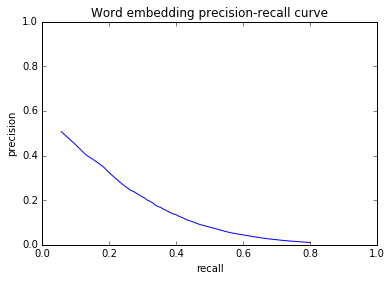

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

# Sort by recall
#df = df.sort_values(by=['recall'], ascending=[1])

# Show and save chart
qx = results.plot(x='recall', y='map', legend=False)
qx.set_xlim([0,1])
qx.set_ylim([0,1])
qx.set_xlabel('recall')
qx.set_ylabel('precision')
qx.set_title('Word embedding precision-recall curve')
fig = qx.get_figure()
fig.savefig('results/part2_embedding_precision-recall.png')

## New query file
Query file for ranking towards other students

In [51]:
std_queries = text_file_parser('data/queries_test_4stp.txt', stopwords, w2v_model, std_queries=True);
print ('Loaded {0} queries.'.format(len(queries)))

# Preview
print ()
print("Example of queries:")
queries.head()

Loaded 1000 queries.

Example of queries:


,sent_id,img_id,caption,vec
1,17984,CbnA_e6AW6U7Ycoa,people group holding award pose picture,"[0.00636434154784, 0.0708179159897, -0.0273282..."
2,17985,XBZPztvt67qkMUdI,man white shirt sitting table cutting meat pla...,"[0.0321689892484, 0.0451594170733, 0.013437090..."
3,17986,PaqtOaYmQmXkqW2i,woman red dress posing hatchet,"[0.0610527054993, -0.00071972244464, 0.0148742..."
4,17987,IPcFtNL-7EQ6Z0yu,soccer play stand soccer ball front,"[0.00167376961247, 0.043567058118, 0.081297381..."
5,17988,IMAD0sq2Fz7HpSgX,white yellow train track,"[-0.0222866877358, 0.0779582923227, 0.04695733..."


In [52]:
output_file = 'output.txt'

# Create outputfile if not already exists
if not os.path.exists(output_file):
    open(output_file, 'w').close()

# Calculate similarity
print ("Calculating precision and recall")
for i,r in std_queries.iterrows():
    print ("Processing query", i) # Print the current query number
    
    rdoc = training_docs
    rdoc["sim"] = 0.0
    
    # Calculate similarity per vector document
    for index, row in rdoc.iterrows():
        try:
            rdoc.set_value(index, "sim", dot(r['vec'], row['vec']))
        except:
            print(index),
            print(row['vec'])
    
    # order by similarity and get top 1000 results
    rdoc = rdoc.sort_values(by=['sim'], ascending=[0])
    rdoc = rdoc[:1000]
    rdoc = rdoc.reset_index() # Current indexes in index column and new ordered index from 0 to N
    
    # Iterare over top 1000 found documents
    for index,row in rdoc.iterrows():
        # Append to the output file
        with open(output_file, 'a') as f:
            # Output in the file is structured as:
            # query_id 0 sent_id 0 similarity_score 0
            f.write(str(r['query_id'])+' 0 '+str(row['sent_id'])+' 0 '+str(row['sim'])+" 0\n")


Calculating precision and recall
Processing query 1
Processing query 2
Processing query 3
Processing query 4
Processing query 5
Processing query 6
Processing query 7
Processing query 8
Processing query 9
Processing query 10
Processing query 11
Processing query 12
Processing query 13
Processing query 14
Processing query 15
Processing query 16
Processing query 17
Processing query 18
Processing query 19
Processing query 20
Processing query 21
Processing query 22
Processing query 23
Processing query 24
Processing query 25
Processing query 26
Processing query 27
Processing query 28
Processing query 29
Processing query 30
Processing query 31
Processing query 32
Processing query 33
Processing query 34
Processing query 35
Processing query 36
Processing query 37
Processing query 38
Processing query 39
Processing query 40
Processing query 41
Processing query 42
Processing query 43
Processing query 44
Processing query 45
Processing query 46
Processing query 47
Processing query 48
Processing query